In [1]:
!nvidia-smi

Fri Apr 15 11:42:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
!pip install datasets
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 582 kB 55.6 MB/s 
     |████████████████████████████████| 6.6 MB 39.9 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 61.2 MB/s 
     |████████████████████████████████| 895 kB 53.4 MB/s 
     |████████████████████████████████| 136 kB 62.4 MB/s 
     |████████████████████████████████| 408 kB 50.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 144 kB 62.0 MB/s 
     |████████████████████████████████| 271 kB 66.6 MB/s 
     |████████████████████████████████| 94 kB 659 kB/s 
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like progra

In [3]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.utils import to_categorical, plot_model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
# from tensorflow.keras import backend as K
# from sklearn.model_selection import train_test_split
# from tensorflow.keras import callbacks
from numpy import asarray
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

import pandas as pd
import numpy as np
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
TensorFlow Version 2.8.0


In [4]:
!git clone https://github.com/darshan154/db2.git

Cloning into 'db2'...
remote: Enumerating objects: 6624, done.
remote: Counting objects: 100% (6624/6624), done.
remote: Compressing objects: 100% (6525/6525), done.
remote: Total 6624 (delta 136), reused 6586 (delta 98), pack-reused 0
Receiving objects: 100% (6624/6624), 9.88 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [5]:
import os
import datasets

def create_image_folder_dataset(root_path):
  """creates `Dataset` from image folder structure"""
  
  # get class names by folders names
  _CLASS_NAMES= os.listdir(root_path)
  # defines `datasets` features`
  features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
  # temp list holding datapoints for creation
  img_data_files=[]
  label_data_files=[]
  # load images into list for creation
  for img_class in os.listdir(root_path):
    for img in os.listdir(os.path.join(root_path,img_class)):
      path_=os.path.join(root_path,img_class,img)
      img_data_files.append(path_)
      label_data_files.append(img_class)
  # create dataset
  ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
  return ds

In [6]:
occupation_ds = create_image_folder_dataset("./db2/data")
occupation_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 1000
})

In [7]:
img_class_labels = occupation_ds.features["label"].names

In [8]:
model_id = "google/vit-base-patch16-224"

In [9]:
from transformers import ViTFeatureExtractor, BeitFeatureExtractor, BeitForImageClassification
from tensorflow import keras 
from tensorflow.keras import layers


feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(feature_extractor.size, feature_extractor.size),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# use keras image data augementation processing
def augmentation(examples):
    # print(examples["img"])
    examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
    return examples


# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

# we are also renaming our label col to labels to use `.to_tf_dataset` later
occupation_ds = occupation_ds.rename_column("label", "labels")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
processed_dataset = occupation_ds.map(process, batched=True)
processed_dataset

# # augmenting dataset takes a lot of time
# processed_dataset = occupation_ds.map(augmentation, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['img', 'labels', 'pixel_values'],
    num_rows: 1000
})

In [11]:
# test size will be 15% of train dataset
test_size=.25

processed_dataset = processed_dataset.shuffle().train_test_split(test_size=test_size)

In [12]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 7
train_batch_size = 64
eval_batch_size = 64
learning_rate = 1e-4
weight_decay_rate=0
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-occupationDs'
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [13]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=False,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

In [14]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(img_class_labels),
    ignore_mismatched_sizes=True,
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics 
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# # compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTForImageClassification.

Some weights of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (768, 1000) in the checkpoint and (768, 5) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (5,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# # alternatively create Image Classification model using Keras Layer and ViTModel 
# # here you can also add the processing layers of keras

# import tensorflow as tf
# from transformers import TFViTModel

# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


# # inputs
# pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')

# # model layer
# vit = base_model.vit(pixel_values)[0]
# classifier = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(vit[:, 0, :])

# # model
# keras_model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

In [16]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=12))
if hub_token:
  callbacks.append(PushToHubCallback(output_dir=output_dir,
                                     hub_model_id=hub_model_id,
                                     hub_token=hub_token))

In [17]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/7
11/11 [==============================] - 235s 19s/step - loss: 1.1322 - accuracy: 0.5398 - top-3-accuracy: 0.8793 - val_loss: 0.7208 - val_accuracy: 0.7360 - val_top-3-accuracy: 0.9640
Epoch 2/7
11/11 [==============================] - 235s 22s/step - loss: 0.4780 - accuracy: 0.8480 - top-3-accuracy: 0.9858 - val_loss: 0.5822 - val_accuracy: 0.7840 - val_top-3-accuracy: 0.9680
Epoch 3/7
11/11 [==============================] - 205s 19s/step - loss: 0.2339 - accuracy: 0.9403 - top-3-accuracy: 0.9957 - val_loss: 0.5659 - val_accuracy: 0.7880 - val_top-3-accuracy: 0.9800
Epoch 4/7
11/11 [==============================] - 235s 22s/step - loss: 0.1271 - accuracy: 0.9730 - top-3-accuracy: 0.9972 - val_loss: 0.5675 - val_accuracy: 0.8160 - val_top-3-accuracy: 0.9560
Epoch 5/7
11/11 [==============================] - 205s 19s/step - loss: 0.0558 - accuracy: 0.9972 - top-3-accuracy: 0.9986 - val_loss: 0.5660 - val_accuracy: 0.8160 - val_top-3-accuracy: 0.9600
Epoch 6/7
11/11 [========

In [18]:
id2label

{'0': 'professor', '1': 'doctor', '2': 'anchor', '3': 'farmer', '4': 'athlete'}

In [19]:
lbls = []
for i in range(len(id2label)):
    lbls.append(id2label[str(i)])
lbls

['professor', 'doctor', 'anchor', 'farmer', 'athlete']

In [20]:
ypred = model.predict(tf_eval_dataset)
ypred = ypred.logits.argmax(-1) 

In [21]:
true_categories = tf.concat([y for x, y in tf_eval_dataset], axis=0)
true_categories = np.array(true_categories)

              precision    recall  f1-score   support

   professor       0.85      0.74      0.79        46
      doctor       0.84      0.79      0.81        52
      anchor       0.77      0.84      0.80        49
      farmer       0.91      0.95      0.93        56
     athlete       0.78      0.83      0.80        47

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.83      0.83      0.83       250



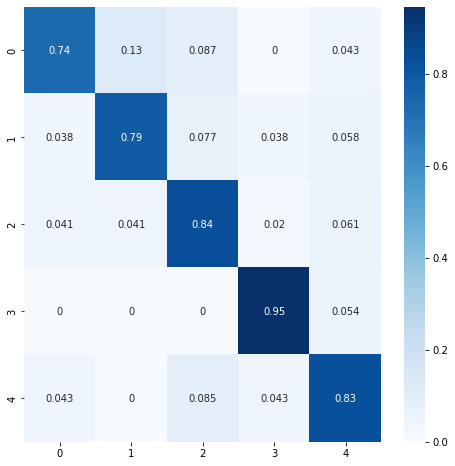

In [22]:
confusionmatrix = confusion_matrix(true_categories, ypred, normalize='true')
plt.figure(figsize = (8, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_categories, ypred, target_names=lbls))

In [23]:
ypred = ypred.reshape((ypred.shape[0], 1))
true_categories = true_categories.reshape((true_categories.shape[0], 1))

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(true_categories, ypred))

Accuracy: 0.832
